In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import data_loaders

import matplotlib.pyplot as plt

In [32]:
coll = data_loaders.training_images()

(360, 360)
<class 'numpy.ndarray'>


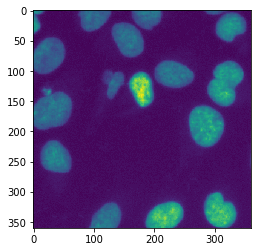

In [33]:
print(coll[0].shape)
print(type(coll))
plt.imshow(coll[0])